## NLP and Sentiment Analysis based Trading Strategy

The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

The data used for this case study will be from three sources:
* **News headlines data compiled from RSS feeds of several news websites**: This news headlines data is complied by different news website and contains the most financially relevant news filtered by human editors. For the purpose of this study, we will only look at the headline, not the details in the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from to 2011-05-02 to 2018-12-28
* **Yahoo finance website for the stock return:** (The return data can be obtained from other website such as yahoo finance)
* **kaggle**: labelled data of of news sentiments obtained for a classification based sentiment analysis model. This data may not be authentic and is used only for demonstration purpose in this case study. 
* Stock market lexicon created based on stock market conversations in microblogging services. The source of this lexicon is *Oliveira, Nuno, Paulo Cortez, and Nelson Areal. "Stock market sentiment lexicon acquisition using microblogging data and statistical measures." Decision Support Systems 85 (2016): 62-73.*



### Loading the python packages

As a first step we check if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies.

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip install nltk==3.4
    !pip install textblob==0.15.3
    !pip install -U spacy==2.3.9
    !python -m spacy download en_core_web_lg
    !pip install backtrader==1.9.74.123    

<ipython-input-1-aec9f833bd5d>:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alessandrocontu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Loading the stock price data

The stock price data is loaded in this step from Yahoo Finance in this step. The loaded data is saved in csv for further use.

In [4]:
from datetime import datetime
import yfinance as yf
import pandas as pd

tickers = ['AAPL','MSFT','AMZN','GOOG','WMT','JPM','TSLA','NFLX','ADBE']
start = datetime(2010,1,1) #'2010-01-01'
end = datetime(2018,12,31) #'2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:    
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker 
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker 
        df_ticker_return = pd.concat([df_ticker_return,data_temp])
#df_ticker_return.to_csv(r'./data/trading/ReturnData.csv')

In [5]:
df_ticker_return

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-01-04 00:00:00-05:00,6.453204,6.485556,6.421456,6.470740,493729600,0.0,0.0,AAPL
2010-01-05 00:00:00-05:00,6.488580,6.518514,6.447762,6.481928,601904800,0.0,0.0,AAPL
2010-01-06 00:00:00-05:00,6.481929,6.507629,6.372173,6.378825,552160000,0.0,0.0,AAPL
2010-01-07 00:00:00-05:00,6.402408,6.409967,6.320772,6.367032,477131200,0.0,0.0,AAPL
2010-01-08 00:00:00-05:00,6.358566,6.409967,6.321074,6.409362,447610800,0.0,0.0,AAPL
...,...,...,...,...,...,...,...,...
2018-12-21 00:00:00-05:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE
2018-12-24 00:00:00-05:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE
2018-12-26 00:00:00-05:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE


The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2010 and the NAs in the data are dropped. Let us look at the news data now.

## Data Preparation

We divide the data preparation into couple of steps as follows:
* Loading and preprocessing the news data
* Preparing the combined data



### Loading and preprocessing News Data

The news data is downloaded from the News RSS feed and the file is downloaded in the json format and the json files for different dates are kept under a zipped folder. 

Let us see the content of the json file

In [15]:
import zipfile
import json
z = zipfile.ZipFile("./data/trading/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  
fileDataSample

'li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr'

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [18]:
#Libraries for processing the news headlines
from lxml import etree
from io import StringIO


#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [19]:
jsonParser(json.loads(fileData))[1][1]

'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

As we can see that using the json parser the news headlines are extracted from the complex html format. This format is good enough to be used for further analysis.

Now, we extract the ticker and the headlines from all the json files and put it in a dataframe. 

In [37]:
from datetime import date

data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("data/trading/Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass  

Let us look at the content of the data

In [41]:
data_df_news=pd.concat(data_df_news)
data_df_news.head(5)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02


As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return.

### Preparing the combined data

In this step we extract the event return, which is the return that corresponds to
the event. We do this because at times the news is reported late and at other times it is
reported after market close. Having a slightly wider window ensures that we capture
the essence of the event. Event return in defined as follows:
$ R_{t-1} + R_t + R_{t+1} $

Where, $ R_{t-1} $, $ R_{t+1} $ are the return before and after the news data and $ R_{t} $ is the return on
the day of the news (i.e. time t). Let us extract the event return from the data:

In [42]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

Now we have all the data in place we will prepare a combined dataframe which will have the news headlines mapped to the date, event Return and stock ticker. This dataframe will be used for further analysis for sentiment analysis model and for building the trading strategy.

In [43]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [44]:
data_df.head(2)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285


Let us save the data in a csv file to be used later, so that the data processing step can be skipped everytime we are looking into analysis. 

In [45]:
#data_df.dropna().to_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|', index=False)

### Loading the preprocessed data
#### Start from this step in case you dont want to run the previous preprocessing steps

In [8]:
data_df = pd.read_csv(r'./data/trading/Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [9]:
print(data_df.shape, data_df.ticker.unique().shape)

(2759, 5) (10,)


In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 10 unique stock tickers with total 2759 rows of data.

## Evaluate Models for Sentiment Analysis

In this section we will go through following three different approaches of getting the sentiments for the news which we will use for building the trading strategy.

* Predefined model-TextBlob package
* Tuned Model-Classification algorithms and LSTM
* Model based on financial lexicon

We will also explore the difference between different ways of performing the sentiment analysis. Let us go through the steps. 

### Predefined model-TextBlob package

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [4]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [6]:
from textblob import TextBlob

TextBlob(text1).sentiment.polarity

0.5

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

In [10]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

In [12]:
data_df.head(5)

,ticker,headline,date,eventRet,Close,sentiment_textblob
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,0.262500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,-0.043750
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,0.166667
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,-0.030556
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,206.07,0.000000


Let us analyse the scatterplot of the sentiments and the return.

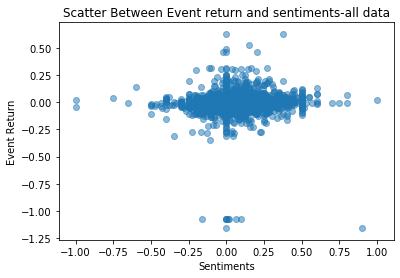

In [13]:
import matplotlib.pyplot as plt

plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [14]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.04274934081383424


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

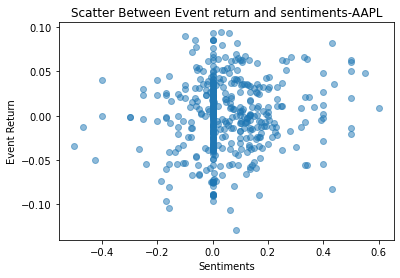

In [55]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

A plot for a single stock (APPL) is also shown. From the scatterplots, we can see that there is not a strong relationship between the news and the sentiments. The correlation between return and sentiments is positive (4.27%), which means that news with positive sentiments leads to positive return and is expected. However, the correlation is not very high. Even looking at the overall scatterplot, we see the majority of the sentiments concentrated around zero. This raises the question of whether a sentiment score trained on movie reviews is appropriate for stock prices.

In [15]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. **This example shows that the context of the training data is important for the sentiment score to be meaningful. There are many predefined packages and functions available for sentiment analysis, but it is important to be careful and have a thorough understanding of the problem’s context before using a function or an algorithm for sentiment analysis**.

### Supervised Learning-Classification algorithms and LSTM

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [16]:
sentiments_data = pd.read_csv(r'data/trading/LabelledNewsData.csv',encoding = "ISO-8859-1")

In [17]:
sentiments_data.head(5)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0


In [18]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


The data has headlines for the news across 30 different stocks, with total 9470 rows, and has sentiments labelled 0 and 1. The headlines are already in almost cleaned. We perform the classification steps that we discussed in chapter 6, using the classification model development python template discussed in that chapter. 

In order to run a supervised learning model, we first need to convert the news headlines into feature representation. The underlying vector representations come from a *spaCy word embedding model*.

In [19]:
import numpy as np
import en_core_web_lg
nlp = en_core_web_lg.load()

#word-embedding
all_vectors = np.array([np.array([token.vector for token in nlp(s) ]).mean(axis=0)*np.ones((300)) \
                           for s in sentiments_data['headline']])

In [20]:
all_vectors[:10]

array([[ 2.47068703e-04,  1.47522390e-01, -9.74819958e-02, ...,
        -9.82979983e-02,  7.15547949e-02, -1.00964447e-02],
       [-6.08016551e-02,  7.67420158e-02, -4.51196022e-02, ...,
        -8.58894214e-02,  1.05378173e-01, -8.10908377e-02],
       [-9.06668752e-02,  9.01247486e-02, -3.16993222e-02, ...,
        -1.24973126e-01,  7.17017502e-02, -1.98813062e-03],
       ...,
       [-1.40954748e-01,  2.61196375e-01, -1.08338706e-01, ...,
        -1.01802781e-01,  1.24807119e-01, -1.03444286e-01],
       [-1.10597655e-01,  2.03657880e-01, -7.82904848e-02, ...,
        -1.00938268e-01,  4.28821407e-02,  4.93573099e-02],
       [-2.66891688e-01,  2.18097657e-01, -9.40152258e-02, ...,
        -1.00876465e-01, -7.52414688e-02,  5.64267635e-02]])

Now that we have prepared the independent variable we train the classification model in a similar manner as discussed in chapter 6. We first divide the data into training set and test set and futher run the key classification models. 

In [21]:
from sklearn.model_selection import train_test_split#, KFold, cross_val_score, GridSearchCV
# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

Running all the classification models

In [22]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

results = []
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

LR: 0.881731 (0.008520) 0.896666 0.874340
[[1043  166]
 [ 191 1441]]
KNN: 0.786395 (0.025171) 0.868608 0.787751
[[ 935  304]
 [ 299 1303]]
CART: 0.689998 (0.015119) 0.999698 0.685674
[[ 775  434]
 [ 459 1173]]
SVM: 0.895004 (0.011195) 0.920803 0.897923
[[1088  144]
 [ 146 1463]]


/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alessandrocontu/anaconda3/envs/finance/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

NN: 0.924574 (0.008259) 0.999698 0.928898
[[1132  100]
 [ 102 1507]]
RF: 0.817774 (0.021121) 0.999698 0.817318
[[ 859  144]
 [ 375 1463]]


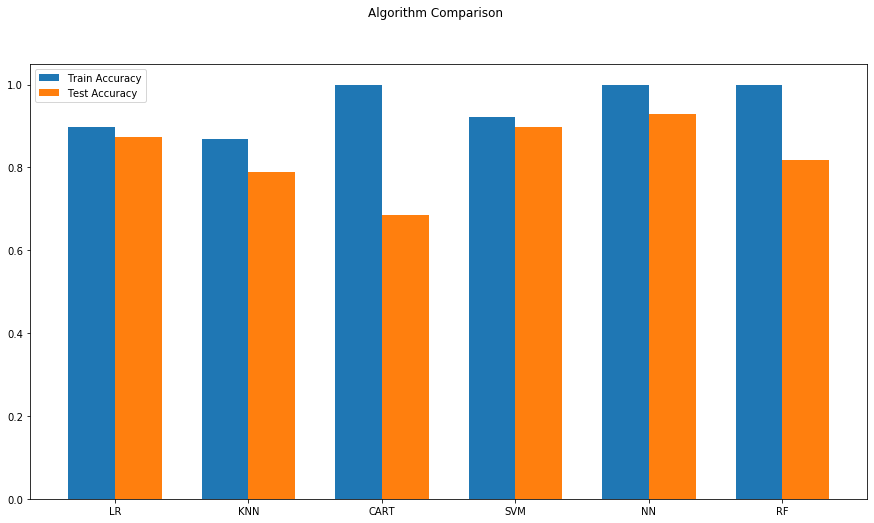

In [24]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Accuracy')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Accuracy')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As we can see the NN model is the best performer with the a training accuracy of 99% and test accuracy of 93%. The performance of Random forest, SVM and Logistic regression are good as well. CART and KNN don't perform as good as other models. CART has higher overfitting as well. 

### LSTM based model

In the above code snippet, we used the some of the model function which look at the individual works in the sentence for training. However, for NLP, RNN based model are preferred over other machine learning models as RNN stores the information for current feature as well neighboring features for prediction. 

For us to be able to feed the data into our LSTM model, all input documents must have the same length. We use the Keras tokenizer function to tokenize the strings and then use texts_to_sequences to make sequences of words. We will limit the maximum review length to max_words by truncating longer reviews and pad shorter reviews with a null value (0).

In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50) #maxlen is the input_length

In [28]:
X_LSTM[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   50,  426,    7,  895, 1488,  145,
         383,  150,  319,    1, 2250,  777],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 1382,   73,
         190,   86,   50,    1, 3476, 1599],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   86,   50,  111,    1,
        3476, 1599,   

Dividing the data into the training and test set. 

In [26]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In the following code snippet, we used Keras library to build a neural network classifier. The network starts with an embedding layer. This layer lets the system expand each token to a larger vector, allowing the network to represent a word in a meaningful way. The layer takes 20,000 as the first argument (i.e., the size of our vocabulary) and 300 as the second input parameter (i.e., the dimension of the embedding). Finally, given that this is a classification problem and the output needs to be labeled as zero or one.

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Embedding
from scikeras.wrappers import KerasClassifier

def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Epoch 1/3
125/125 [==============================] - 673s 5s/step - loss: 0.3699 - accuracy: 0.8257 - val_loss: 0.1170 - val_accuracy: 0.9563
Epoch 2/3
125/125 [==============================] - 750s 6s/step - loss: 0.0532 - accuracy: 0.9842 - val_loss: 0.0702 - val_accuracy: 0.9751
Epoch 3/3
125/125 [==============================] - 848s 7s/step - loss: 0.0167 - accuracy: 0.9957 - val_loss: 0.0673 - val_accuracy: 0.9747


KerasClassifier(
	model=<function create_model at 0x28aaa23a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.4
	shuffle=True
	run_eagerly=False
	epochs=3
	class_weight=None
)

In [29]:
# Train results
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

89/89 [==============================] - 16s 179ms/step


Computing the accuracy and confusion metrics. 

In [32]:
print("TRAIN ACCURACY: "+str(train_result_LSTM))
print("TEST ACCURACY: "+ str(test_result_LSTM))

TRAIN ACCURACY: 0.9891386332780208
TEST ACCURACY: 0.970080957409363


In [88]:
#confusion_matrix(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

89/89 [==============================] - 14s 160ms/step


array([[1199,   65],
       [  35, 1542]])

In [33]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)

In [34]:
names.append("LSTM")

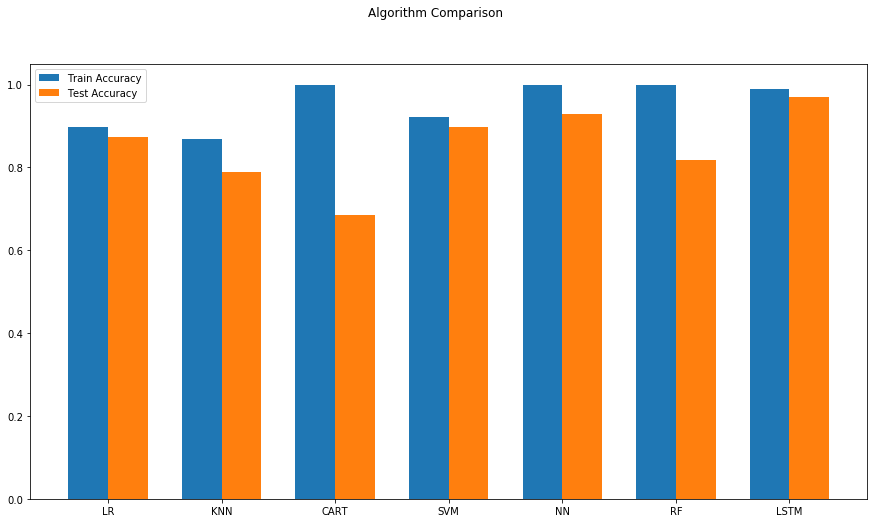

In [36]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Accuracy')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Accuracy')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As expected, the LSTM model has the best performance in the test set as compared to all other models that we saw before. Let us use LSTM model for the computation of the sentiments in the data. 

In [37]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [38]:
Y_LSTM = model_LSTM.predict(X_LSTM)

87/87 [==============================] - 14s 165ms/step


In [39]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [40]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.13494611094961662


In [41]:
data_df.head(5)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,0.262500,0
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,-0.043750,1
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,0.166667,1
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,-0.030556,1
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,206.07,0.000000,0


### Unsupervised - Model based on financial lexicon

Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.
VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package. 

In [42]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('./data/trading/LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alessandrocontu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Example of extracting sentiment score for a sentence:

In [43]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [44]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [45]:
vader_sentiments = np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2759,)

In [46]:
data_df['sentiment_lex'] = vader_sentiments

In [47]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(corrlation)

0.10477850058004676


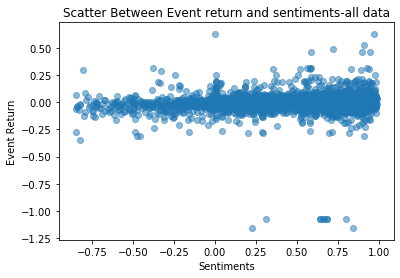

In [48]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

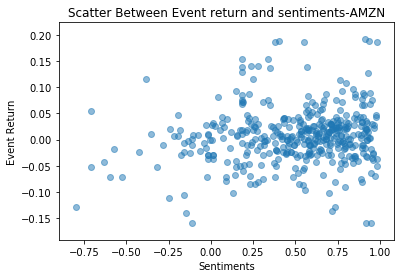

In [49]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We see a positive correlation between the event return and sentiments. We will look deeper into the comparison of different types of the sentiment analysis in the next section.

In [51]:
data_df.head(5)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM,sentiment_lex
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,0.262500,0,0.2115
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,-0.043750,1,0.8575
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,0.166667,1,0.6971
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,-0.030556,1,0.7751
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,206.07,0.000000,0,-0.0413


In [110]:
#data_df.to_csv(r'./data/trading/DataWithSentimentsResults.csv', sep='|', index=False)

## Exploratory Data Analysis and comparison
In this section, we compare the sentiments computed using the different techniques presented above.

In [112]:
data_df = pd.read_csv(r'./data/trading/DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

Let us look at the sample headlines and the the sentiments from three different methodology, followed by the analysis using visualization. 

In [52]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]

from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,1,0.8575


Looking at one of the headlines, the sentiment from this sentence is positive. How‐ ever, the TextBlob sentiment result is smaller in magnitude, suggesting that the sentiment is more neutral. This points back to the previous assumption that the model trained on movie sentiments likely will not be accurate for stock sentiments. The classification-based model correctly suggests the sentiment is positive, but it is binary.

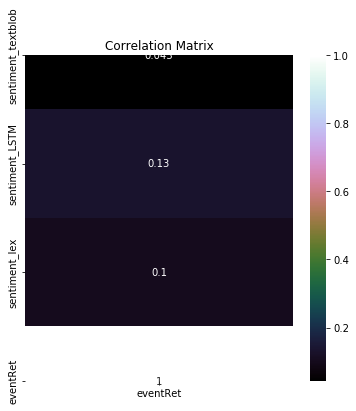

In [54]:
import seaborn as sns
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(6,6))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

Let us review the correlation of all the sentiments from different methodologies versus returns: all sentiments have positive relationships with the returns, which is intuitive and expected. The sentiments from the lexicon methodology are highest, which means the stock’s event return can be predicted the best using the lexicon methodology. Recall that this methodology leverages financial terms in the model. The LSTM-based method also performs better than the TextBlob approach, but the performance is slightly worse compared to the lexicon-based methodology. **This is what the autor wrote, but during my experiment, it's the opposite: the LSTM approach is better**.

In [55]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [57]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(5)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.019830,0.169344,0.138296
NFLX,0.092630,0.130740,0.218663
MSFT,-0.025318,0.215735,0.034494
GOOG,0.044213,0.195898,0.196258
JPM,-0.160327,0.165192,0.025343


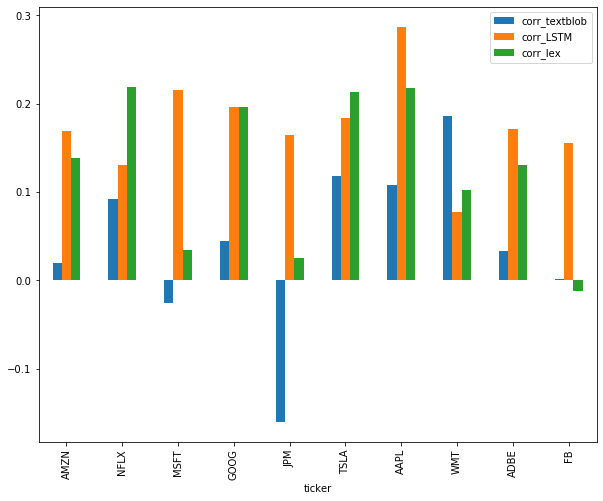

In [61]:
corr_df.to_csv("./data/trading/correlation.csv")     
#tickers = ['AAPL','MSFT','AMZN','GOOG','BABA','WMT','V','JPM','TSLA']
corr_df.loc[corr_df.index].plot.bar(figsize = (10,8))
plt.show()

Looking at the chart, the correlation from the lexicon and LSTM methodology are the highest across all stock tickers. The TextBlob-based sentiments show unintuitive results in some cases, such as with JPM.

Let us look at the scatterplot for lexicon versus TextBlob methodologies for AMZN and GOOG. We will set the LSTM-based method aside since the binary sentiments will not be meaningful in the scatterplot

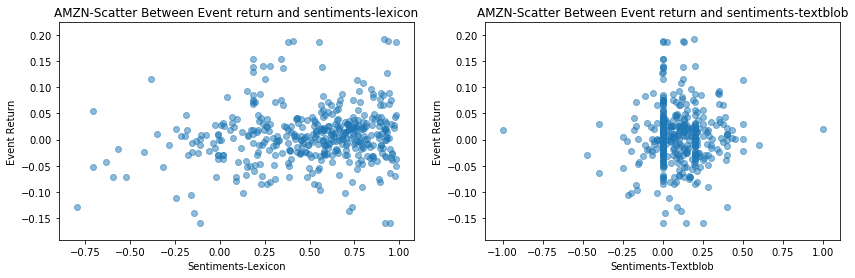

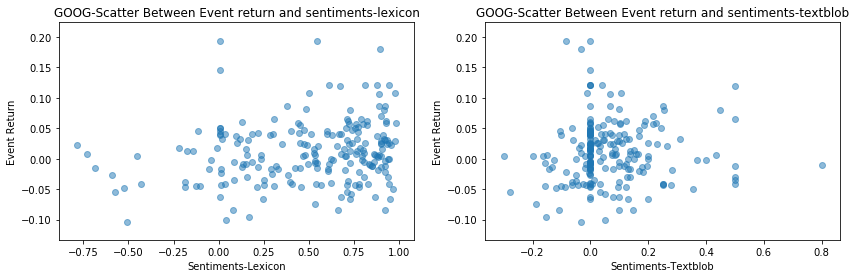

In [62]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()
    

The lexicon-based sentiments on the left show a positive relationship between the sentiments and returns. Some of the points with the highest returns are associated with the most positive news. Also, the scatterplot is more uniformly distributed in the case of lexicon as compared to TextBlob. The sentiments for TextBlob are concentrated around zero, probably because the model is not able to categorize financial sentiments well. For the trading strategy, we will be using the lexicon-based sentiments, as these are the most appropriate based on the analysis in this section. The LSTM-based sentiments are good as well, but they are labeled either zero or one. The more granular lexicon-based sentiments are preferred.

## Model Evaluation - Building a Trading Strategy

The sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with positive score and selling the stocks with negative score. The sentiments can also be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy. 

In the trading strategy in this case study we buy and sell stock as per the current stock sentiments : 
* Buy a stock when the change in sentiment score (Current sentiment score - previous sentiment score) is greater than .5 and sell a stock when the change in sentiment score is less than -.5.
* Additionally, we check for 15 days moving average while buying and selling and buy or sell in a unit of 100. 

Obviusly, there can be many ways to create the trading strategy based in sentiments, by varying the threshold, or changing the number of units based on the initial cash available.

We use lexicon based sentiments for the trading strategy.


## Setting up the strategy 
Here we use backtrader which is a Python based API for writing and backtesting trading strategy. . Backtrader allows you to focus on writing reusable trading strategies, indicators and analyzers instead of having to spend time building infrastructure. we have a convenient framework to backtest and write our trading strategy. We used the Quickstart code in the docs (i.e. Refer to https://www.backtrader.com/docu/quickstart/quickstart/) as a base and modified it to include the sentiment scores.

We implement a simple strategy to buy if the previous day’s sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5.


The following function contains two classes: 
* Sentiment:
* SentimentStrat: The "next" function of this class implements the actual trading strategy. 


In [63]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return       
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)   



### Function for running the trading strategy

Now, we write a generic function to run the strategy for any stock. We specified the “ticker” stock feeds to be pulled from Yahoo Finance, set an initial amount of $100,000, a fixed size of 100 lots per trade.

In [64]:
def run_strategy(ticker, start, end):
    print(ticker)    
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)    
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run() 
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

### Results for Individual Stocks

First running the strategy for google

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.21
2012-04-13, BUY EXECUTED, Price: 16.13, Cost: 1612.83, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.31
2012-10-19, SELL EXECUTED, Price: 17.57, Cost: 1612.83, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.53, NET 144.53
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.47
2013-01-11, BUY EXECUTED, Price: 18.48, Cost: 1848.07, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.61
2014-07-18, SELL EXECUTED, Price: 29.57, Cost: 1848.07, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 1108.81, NET 1108.81
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 29.67
2014-07-21, BUY EXECUTED, Price: 29.51, Cost: 2950.65, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 28.70
2014-09-15, SELL EXECUTED, Price: 28.57, Cost: 2950.65, Comm 0.00
2014

<IPython.core.display.Javascript object>


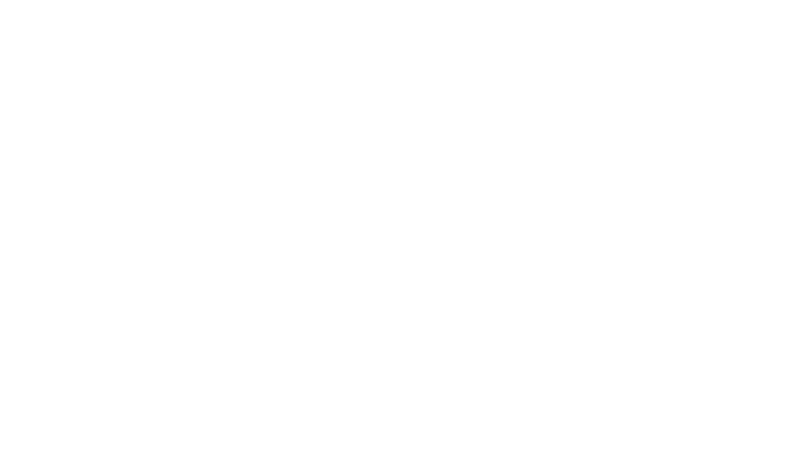

Start Portfolio value: 100000.00
Final Portfolio Value: 102485.95
Profit: 2485.95



(16.573129653930664, 2485.9493255615234)

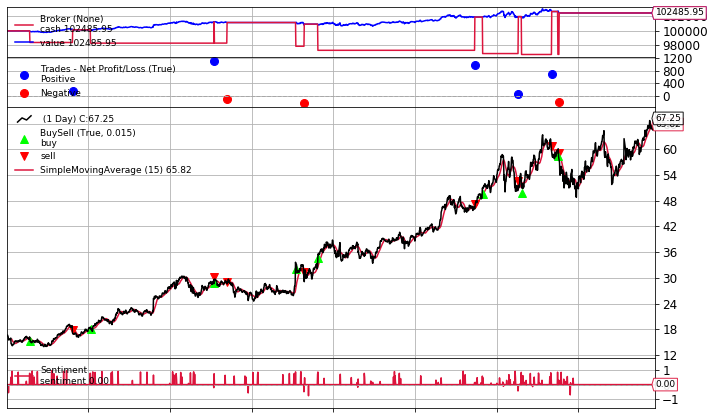

In [66]:
from datetime import datetime

ticker = 'GOOG'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
start = datetime(2012,1,1)
end = datetime(2019,12,12)
run_strategy(ticker, start=start, end=end)

The chart is divided into three panels. 

* Top Panel : Top panel is the cash value observer which as the name implies keeps track of the Cash and total portolio Value (including cash) during the life of the backtesting run. As we can see that we started with 100000.00 and final value at the end is 102485.95 as shown in this panel.

* Second Panel : This panel is Trade Observer which shows, at the end of a trade, the actual Profit and Loss. A trade is defined as opening a position and taking the position back to 0 (directly or crossing over from long to short or short to long). Five out of eight actions of buy and sell are profitable for the strategy. 

* Third Panel : This panel is Buy Sell observer which plots (on top of the prices) where buy and sell operations have taken place. In general we see that (specially around 2018) the buy action takes place when the stock price is increasing and the sell action takes place when the stock price has started declining.   

* Bottom Panel : This panel shows the sentiment score, varying between -1 and 1.

Now we choose one of the days on which buy was triggered and we look at the news on that data and previous day.

In [67]:
GOOG_ticker= data_df[data_df['ticker'].isin([ticker])]
New= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-17']['headline'])
Old= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-16']['headline'])
print("Current News:",New,"\n\n","Previous News:", Old)

Current News: ["Axiom Securities has upgraded Google (GOOG +13.4%, GOOGL +14.8%) to Buy following the company's Q2 beat and investor-pleasing comments about spending discipline, potential capital returns, and YouTube/mobile growth. MKM has launched coverage at Buy, and plenty of other firms have hiked their targets. Google's market cap is now above $450B."] 

 Previous News: ["While Google's (GOOG, GOOGL) Q2 revenue slightly missed estimates when factoring traffic acquisitions costs (TAC), its ex-TAC revenue of $14.35B was slightly above a $14.3B consensus. The reason: TAC fell to 21% of ad revenue from Q1's 22% and Q2 2014's 23%. That also, of course, helped EPS beat estimates.", 'Google (NASDAQ:GOOG): Q2 EPS of $6.99 beats by $0.28.']


Clearly the News on the current day has positive sentiment as compared to the news at the previous day causing the buy to be triggered. Now, we run the strategy for Apple.

AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.34
2013-12-16, BUY EXECUTED, Price: 17.36, Cost: 1735.58, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.78
2014-09-26, SELL EXECUTED, Price: 21.93, Cost: 1735.58, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 457.06, NET 457.06
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.80
2014-10-22, BUY EXECUTED, Price: 22.89, Cost: 2288.55, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 28.97
2015-06-12, SELL EXECUTED, Price: 28.88, Cost: 2288.55, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 599.82, NET 599.82
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 26.10
2015-09-15, BUY EXECUTED, Price: 26.24, Cost: 2623.95, Comm 0.00
2015-12-14, Previous Sentiment 0.24, New Sentiment -0.62 SELL CREATE, 25.57
2015-12-15, SELL EXECUTED, Price: 25.44, Cost: 2623.95, Comm 0.00
2015-1

<IPython.core.display.Javascript object>


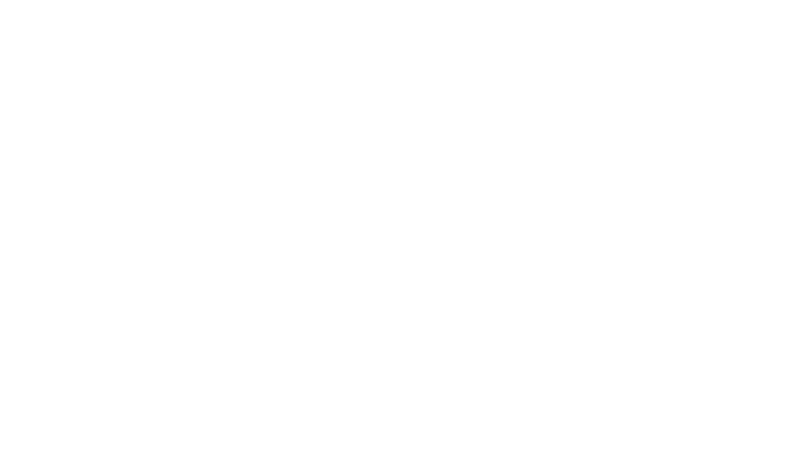

Start Portfolio value: 100000.00
Final Portfolio Value: 100913.93
Profit: 913.93



(12.433823585510254, 913.9345400780585)

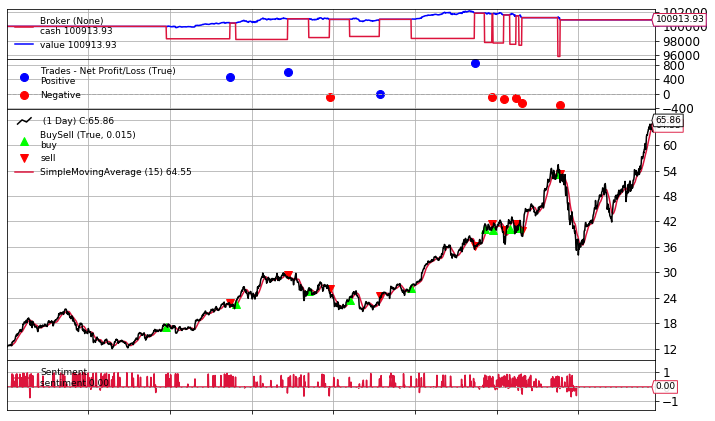

In [68]:
ticker = 'AAPL'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = start, end = end)

Top Panel : The CashValue shows overall profit of 913.93.

Second Panel : A Trade Observer shows that 4 out of 9 actions are profitable. 

Third Panel : A BuySell observer shows that in general the buy action takes place when the stock price is increasing and the sell action takes place when the stock price has started declining.   

Forth Panel : It shows high number of positive sentiment for the AAPL.

### Results for Multiple Stocks

AMZN
Starting Portfolio Value: 100000.00
2013-01-30, Previous Sentiment 0.40, New Sentiment 0.95 BUY CREATE, 13.64
2013-01-31, BUY EXECUTED, Price: 13.55, Cost: 1355.20, Comm 0.00
2013-04-18, Previous Sentiment 0.89, New Sentiment 0.38 SELL CREATE, 12.97
2013-04-19, SELL EXECUTED, Price: 12.91, Cost: 1355.20, Comm 0.00
2013-04-19, OPERATION PROFIT, GROSS -64.40, NET -64.40
2013-10-25, Previous Sentiment 0.15, New Sentiment 0.84 BUY CREATE, 18.17
2013-10-28, BUY EXECUTED, Price: 18.00, Cost: 1799.60, Comm 0.00
2014-02-03, Previous Sentiment 0.56, New Sentiment -0.15 SELL CREATE, 17.31
2014-02-04, SELL EXECUTED, Price: 17.48, Cost: 1799.60, Comm 0.00
2014-02-04, OPERATION PROFIT, GROSS -51.65, NET -51.65
2014-05-20, Previous Sentiment -0.59, New Sentiment 0.08 BUY CREATE, 15.06
2014-05-21, BUY EXECUTED, Price: 15.11, Cost: 1511.05, Comm 0.00
2014-11-05, Previous Sentiment 0.79, New Sentiment 0.02 SELL CREATE, 14.83
2014-11-06, SELL EXECUTED, Price: 14.83, Cost: 1511.05, Comm 0.00
2014-11

<IPython.core.display.Javascript object>


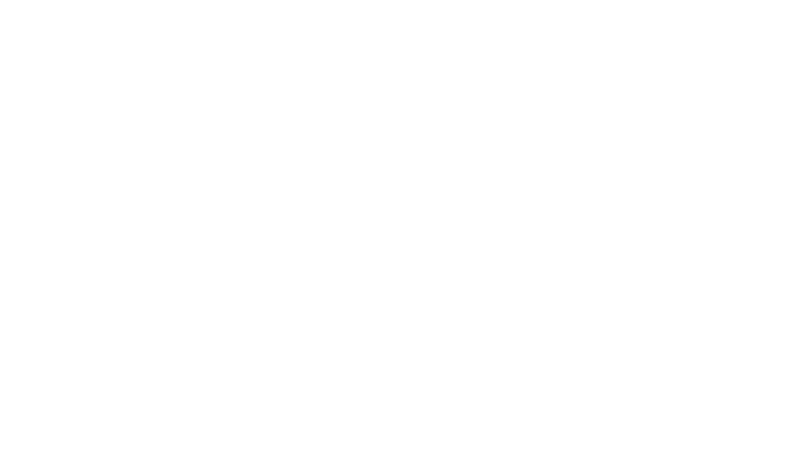

Start Portfolio value: 100000.00
Final Portfolio Value: 103789.20
Profit: 3789.20

NFLX
Starting Portfolio Value: 100000.00
2012-02-08, Previous Sentiment 0.08, New Sentiment 0.62 BUY CREATE, 17.71
2012-02-09, BUY EXECUTED, Price: 17.77, Cost: 1777.29, Comm 0.00
2012-02-21, Previous Sentiment 0.92, New Sentiment -0.24 SELL CREATE, 16.77
2012-02-22, SELL EXECUTED, Price: 16.42, Cost: 1777.29, Comm 0.00
2012-02-22, OPERATION PROFIT, GROSS -135.71, NET -135.71
2012-03-21, Previous Sentiment 0.10, New Sentiment 0.73 BUY CREATE, 17.16
2012-03-22, BUY EXECUTED, Price: 17.15, Cost: 1714.71, Comm 0.00
2012-05-31, Previous Sentiment 0.92, New Sentiment 0.11 SELL CREATE, 9.06
2012-06-01, SELL EXECUTED, Price: 8.71, Cost: 1714.71, Comm 0.00
2012-06-01, OPERATION PROFIT, GROSS -844.00, NET -844.00
2012-07-03, Previous Sentiment -0.07, New Sentiment 0.85 BUY CREATE, 10.29
2012-07-05, BUY EXECUTED, Price: 10.62, Cost: 1061.86, Comm 0.00
2014-10-15, Previous Sentiment 0.93, New Sentiment -0.02 SELL C

Start Portfolio value: 100000.00
Final Portfolio Value: 103934.08
Profit: 3934.08

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.21
2012-04-13, BUY EXECUTED, Price: 16.13, Cost: 1612.83, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.31
2012-10-19, SELL EXECUTED, Price: 17.57, Cost: 1612.83, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.53, NET 144.53
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.47
2013-01-11, BUY EXECUTED, Price: 18.48, Cost: 1848.07, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.61
2014-07-18, SELL EXECUTED, Price: 29.57, Cost: 1848.07, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 1108.81, NET 1108.81
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 29.67
2014-07-21, BUY EXECUTED, Price: 29.51, Cost: 2950.65, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL C

Start Portfolio value: 100000.00
Final Portfolio Value: 101050.33
Profit: 1050.33

AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.34
2013-12-16, BUY EXECUTED, Price: 17.36, Cost: 1735.58, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.78
2014-09-26, SELL EXECUTED, Price: 21.93, Cost: 1735.58, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 457.06, NET 457.06
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.80
2014-10-22, BUY EXECUTED, Price: 22.89, Cost: 2288.55, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 28.97
2015-06-12, SELL EXECUTED, Price: 28.88, Cost: 2288.55, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 599.82, NET 599.82
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 26.10
2015-09-15, BUY EXECUTED, Price: 26.24, Cost: 2623.95, Comm 0.00
2015-12-14, Previous Sentiment 0.24, New Sentiment -0.62 SELL CRE

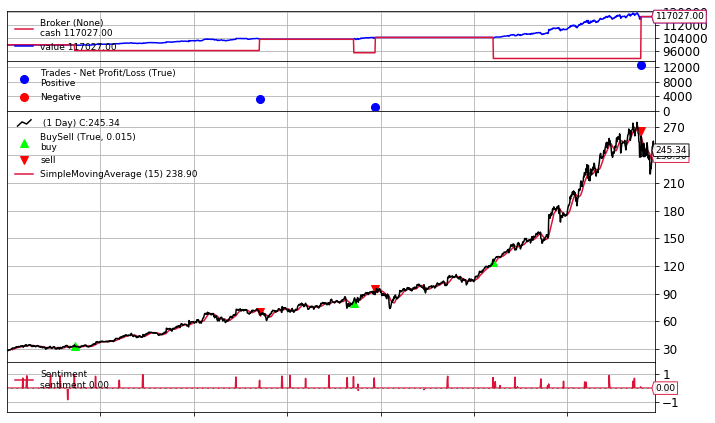

In [82]:
results_tickers = {}
tickers = corr_df.index[:-1]
for ticker in tickers:    
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

In [83]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AMZN,NFLX,MSFT,GOOG,JPM,TSLA,AAPL,WMT,ADBE
PerUnitStartPrice,8.951500,10.320000,21.238758,16.573130,24.695122,1.872000,12.433825,15.429744,28.570000
StrategyProfit,3789.199829,25180.713654,3934.077853,2485.949326,1820.432903,1050.333261,913.934600,349.680963,17027.000427


The strategy yield an overall profit be for all the stock. Now we run the strategy varying the time period.

### Varying the strategy time period

In this step we run the strategy for differnt time periods and look at the results. We first run it for the time period between 2012 and 2014.

AMZN
Starting Portfolio Value: 100000.00
2013-01-30, Previous Sentiment 0.40, New Sentiment 0.95 BUY CREATE, 13.64
2013-01-31, BUY EXECUTED, Price: 13.55, Cost: 1355.20, Comm 0.00
2013-04-18, Previous Sentiment 0.89, New Sentiment 0.38 SELL CREATE, 12.97
2013-04-19, SELL EXECUTED, Price: 12.91, Cost: 1355.20, Comm 0.00
2013-04-19, OPERATION PROFIT, GROSS -64.40, NET -64.40
2013-10-25, Previous Sentiment 0.15, New Sentiment 0.84 BUY CREATE, 18.17
2013-10-28, BUY EXECUTED, Price: 18.00, Cost: 1799.60, Comm 0.00
2014-02-03, Previous Sentiment 0.56, New Sentiment -0.15 SELL CREATE, 17.31
2014-02-04, SELL EXECUTED, Price: 17.48, Cost: 1799.60, Comm 0.00
2014-02-04, OPERATION PROFIT, GROSS -51.65, NET -51.65
2014-05-20, Previous Sentiment -0.59, New Sentiment 0.08 BUY CREATE, 15.06
2014-05-21, BUY EXECUTED, Price: 15.11, Cost: 1511.05, Comm 0.00
2014-11-05, Previous Sentiment 0.79, New Sentiment 0.02 SELL CREATE, 14.83
2014-11-06, SELL EXECUTED, Price: 14.83, Cost: 1511.05, Comm 0.00
2014-11

<IPython.core.display.Javascript object>


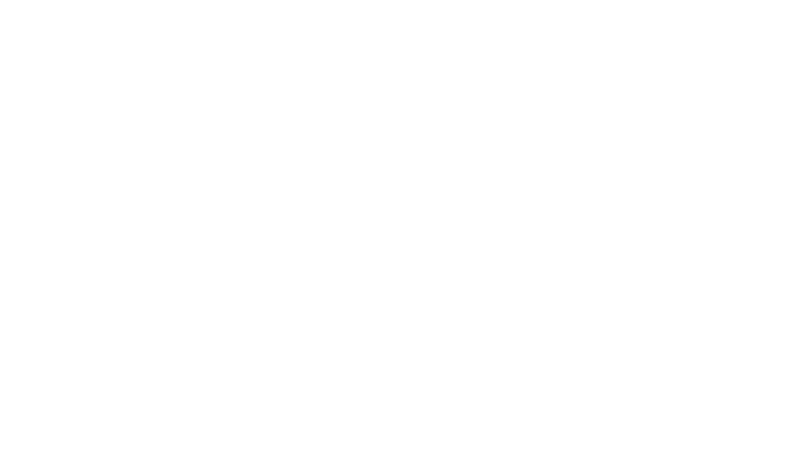

Start Portfolio value: 100000.00
Final Portfolio Value: 104316.60
Profit: 4316.60

NFLX
Starting Portfolio Value: 100000.00
2012-02-08, Previous Sentiment 0.08, New Sentiment 0.62 BUY CREATE, 17.71
2012-02-09, BUY EXECUTED, Price: 17.77, Cost: 1777.29, Comm 0.00
2012-02-21, Previous Sentiment 0.92, New Sentiment -0.24 SELL CREATE, 16.77
2012-02-22, SELL EXECUTED, Price: 16.42, Cost: 1777.29, Comm 0.00
2012-02-22, OPERATION PROFIT, GROSS -135.71, NET -135.71
2012-03-21, Previous Sentiment 0.10, New Sentiment 0.73 BUY CREATE, 17.16
2012-03-22, BUY EXECUTED, Price: 17.15, Cost: 1714.71, Comm 0.00
2012-05-31, Previous Sentiment 0.92, New Sentiment 0.11 SELL CREATE, 9.06
2012-06-01, SELL EXECUTED, Price: 8.71, Cost: 1714.71, Comm 0.00
2012-06-01, OPERATION PROFIT, GROSS -844.00, NET -844.00
2012-07-03, Previous Sentiment -0.07, New Sentiment 0.85 BUY CREATE, 10.29
2012-07-05, BUY EXECUTED, Price: 10.62, Cost: 1061.86, Comm 0.00
2014-10-15, Previous Sentiment 0.93, New Sentiment -0.02 SELL C

2018-10-09, Previous Sentiment 0.71, New Sentiment 0.01 SELL CREATE, 105.95
2018-10-10, SELL EXECUTED, Price: 104.98, Cost: 8167.41, Comm 0.00
2018-10-10, OPERATION PROFIT, GROSS 2331.05, NET 2331.05
2019-12-11, (MA Period 15) Ending Value 103934.08
Start Portfolio value: 100000.00
Final Portfolio Value: 103934.08
Profit: 3934.08

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.21
2012-04-13, BUY EXECUTED, Price: 16.13, Cost: 1612.83, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.31
2012-10-19, SELL EXECUTED, Price: 17.57, Cost: 1612.83, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.53, NET 144.53
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.47
2013-01-11, BUY EXECUTED, Price: 18.48, Cost: 1848.07, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.61
2014-07-18, SELL EXECUTED, Price: 29.57, Cost: 1848.07, Comm 0.00
2014-07-18

2018-03-12, Previous Sentiment -0.36, New Sentiment 0.32 BUY CREATE, 23.03
2018-03-13, BUY EXECUTED, Price: 21.91, Cost: 2190.73, Comm 0.00
2018-03-19, Previous Sentiment 0.32, New Sentiment -0.40 SELL CREATE, 20.90
2018-03-20, SELL EXECUTED, Price: 20.99, Cost: 2190.73, Comm 0.00
2018-03-20, OPERATION PROFIT, GROSS -91.60, NET -91.60
2018-06-01, Previous Sentiment -0.60, New Sentiment 0.43 BUY CREATE, 19.45
2018-06-04, BUY EXECUTED, Price: 19.62, Cost: 1962.27, Comm 0.00
2018-07-03, Previous Sentiment 0.75, New Sentiment -0.20 SELL CREATE, 20.72
2018-07-05, SELL EXECUTED, Price: 20.92, Cost: 1962.27, Comm 0.00
2018-07-05, OPERATION PROFIT, GROSS 129.47, NET 129.47
2018-10-23, Previous Sentiment -0.17, New Sentiment 0.39 BUY CREATE, 19.61
2018-10-24, BUY EXECUTED, Price: 20.07, Cost: 2007.00, Comm 0.00
2019-12-11, (MA Period 15) Ending Value 100956.60
Start Portfolio value: 100000.00
Final Portfolio Value: 100956.60
Profit: 956.60

AAPL
Starting Portfolio Value: 100000.00
2013-12-13, P

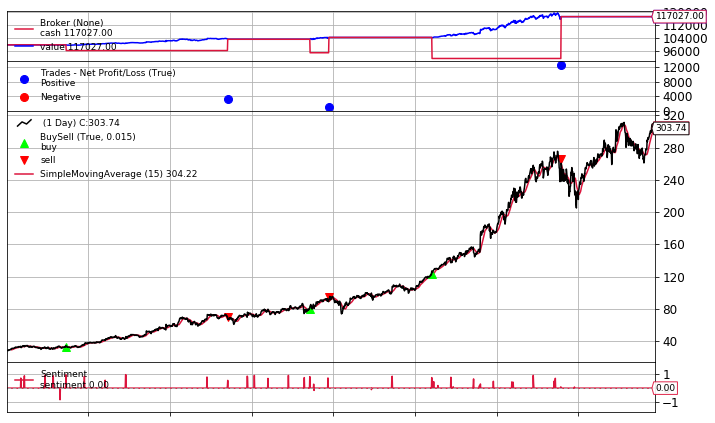

In [84]:
results_tickers = {}
for ticker in tickers:  
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = start, end = end)

In [85]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["StockPriceBeginning", 'StrategyProfit'])])

,AMZN,NFLX,MSFT,GOOG,JPM,TSLA,AAPL,WMT,ADBE
StockPriceBeginning,8.951500,10.320000,21.238758,16.573130,24.695118,1.872000,12.433827,15.429749,28.570000
StrategyProfit,4316.599274,25180.713654,3934.079893,2485.949326,1820.433631,956.599855,913.937054,1192.210829,17027.000427


The strategy yield an overall profit for all the stocks except two. Now we run the strategy between 2016 and 2018. 

AMZN
Starting Portfolio Value: 100000.00
2016-02-29, Previous Sentiment 0.02, New Sentiment 0.88 BUY CREATE, 27.63
2016-03-01, BUY EXECUTED, Price: 27.81, Cost: 2781.45, Comm 0.00
2016-04-28, Previous Sentiment 0.96, New Sentiment 0.31 SELL CREATE, 30.10
2016-04-29, SELL EXECUTED, Price: 33.30, Cost: 2781.45, Comm 0.00
2016-04-29, OPERATION PROFIT, GROSS 548.55, NET 548.55
2016-05-10, Previous Sentiment 0.02, New Sentiment 0.57 BUY CREATE, 35.15
2016-05-11, BUY EXECUTED, Price: 35.29, Cost: 3528.95, Comm 0.00
2016-06-15, Previous Sentiment 0.71, New Sentiment 0.07 SELL CREATE, 35.71
2016-06-16, SELL EXECUTED, Price: 35.60, Cost: 3528.95, Comm 0.00
2016-06-16, OPERATION PROFIT, GROSS 31.30, NET 31.30
2016-07-13, Previous Sentiment 0.07, New Sentiment 0.60 BUY CREATE, 37.13
2016-07-14, BUY EXECUTED, Price: 37.44, Cost: 3744.30, Comm 0.00
2016-07-26, Previous Sentiment 0.46, New Sentiment -0.28 SELL CREATE, 36.78
2016-07-27, SELL EXECUTED, Price: 36.90, Cost: 3744.30, Comm 0.00
2016-07-27

<IPython.core.display.Javascript object>


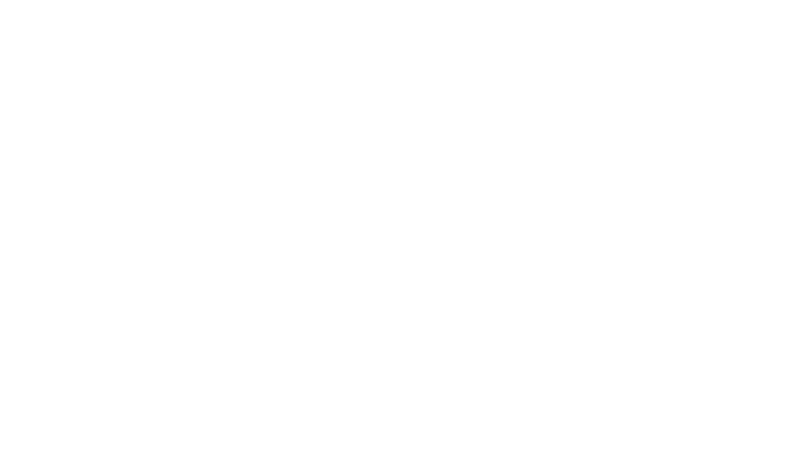

Start Portfolio value: 100000.00
Final Portfolio Value: 102393.15
Profit: 2393.15

NFLX
Starting Portfolio Value: 100000.00
2016-05-26, Previous Sentiment 0.04, New Sentiment 0.58 BUY CREATE, 102.81
2016-05-27, BUY EXECUTED, Price: 102.44, Cost: 10244.00, Comm 0.00
2016-06-13, Previous Sentiment 0.58, New Sentiment -0.32 SELL CREATE, 93.85
2016-06-14, SELL EXECUTED, Price: 94.16, Cost: 10244.00, Comm 0.00
2016-06-14, OPERATION PROFIT, GROSS -828.00, NET -828.00
2016-07-11, Previous Sentiment -0.54, New Sentiment 0.71 BUY CREATE, 94.67
2016-07-12, BUY EXECUTED, Price: 95.07, Cost: 9507.00, Comm 0.00
2016-07-19, Previous Sentiment 0.61, New Sentiment -0.25 SELL CREATE, 85.84
2016-07-20, SELL EXECUTED, Price: 86.67, Cost: 9507.00, Comm 0.00
2016-07-20, OPERATION PROFIT, GROSS -840.00, NET -840.00
2016-10-03, Previous Sentiment 0.09, New Sentiment 0.60 BUY CREATE, 102.63
2016-10-04, BUY EXECUTED, Price: 103.19, Cost: 10319.00, Comm 0.00
2016-11-09, Previous Sentiment 0.66, New Sentiment -0

Starting Portfolio Value: 100000.00
2016-03-15, Previous Sentiment 0.09, New Sentiment 0.66 BUY CREATE, 23.90
2016-03-16, BUY EXECUTED, Price: 23.91, Cost: 2390.77, Comm 0.00
2016-07-26, Previous Sentiment 0.93, New Sentiment 0.14 SELL CREATE, 22.23
2016-07-27, SELL EXECUTED, Price: 23.98, Cost: 2390.77, Comm 0.00
2016-07-27, OPERATION PROFIT, GROSS 6.74, NET 6.74
2016-12-13, Previous Sentiment 0.15, New Sentiment 0.74 BUY CREATE, 26.77
2016-12-14, BUY EXECUTED, Price: 26.73, Cost: 2673.13, Comm 0.00
2017-09-22, Previous Sentiment 0.58, New Sentiment 0.08 SELL CREATE, 35.73
2017-09-25, SELL EXECUTED, Price: 35.29, Cost: 2673.13, Comm 0.00
2017-09-25, OPERATION PROFIT, GROSS 855.48, NET 855.48
2017-11-06, Previous Sentiment 0.14, New Sentiment 0.64 BUY CREATE, 40.99
2017-11-07, BUY EXECUTED, Price: 40.91, Cost: 4091.35, Comm 0.00
2017-12-08, Previous Sentiment 0.57, New Sentiment -0.02 SELL CREATE, 39.99
2017-12-11, SELL EXECUTED, Price: 39.95, Cost: 4091.35, Comm 0.00
2017-12-11, OPERA

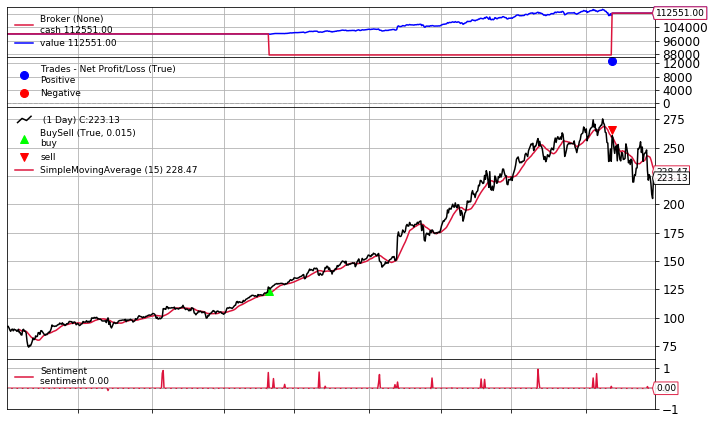

In [86]:
results_tickers = {}
for ticker in tickers: 
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2016-01-01', end = '2018-12-31')

In [87]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AMZN,NFLX,MSFT,GOOG,JPM,TSLA,AAPL,WMT,ADBE
PerUnitStartPrice,31.849501,109.959999,48.608990,37.091999,50.486786,14.894000,23.946917,17.385752,91.970001
StrategyProfit,2393.149757,25019.999695,3214.007226,1571.500015,0.000000,725.733185,-63.482028,193.498299,12551.000214


We see a good performance of the sentiment based strategy across all the stocks and we can conclude that our sentiment based strategy performs quite well on different time period. The strategy can be further be tweaked to modify the threshold, order size. Additional metrics such as sharpe ratio and maximum drawdown can also be used to understand the performance of the stratefy. The sentiments can also be used along with the other features such as correlated variables and technical indicators for prediction.   

**Conclusion**

 We performed a comparison of the models and concluded that one of the most important step is training the model for sentiment analysis is training it using the domain-specific vocabulary. 

We further used the sentiments as signals to develop different trading strategy. This initial result suggests that the model trained on a financial lexicon based sentiments could prove a viable model for a trading strategy. 

Additional improvements to this can be made by using more complex pre-trained sentiment analysis models such as Bert by google or diffeent pre-trained NLP models available in open source platforms. Existing NLP libraries fill in some of the pre-processing and encoding steps to allow us to focus on the inference step.
